In [584]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [585]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196'

TARGETNAME = 'placement'

In [586]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_matches.pickle'))

In [587]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Guardian,Set7_Guild,...,TFT7_TahmKench_item2,TFT7_Senna_item0,TFT7_Vladimir_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Aatrox_item0,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2
0,NA1_4357487638,5,TFT6_Augment_PortableForge,TFT7_Augment_DragonHorde,TFT7_Augment_WhispersEmblem2,1.0,0.0,2.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NA1_4357487638,3,TFT6_Augment_ThreesCompany,TFT7_Augment_FirstAidKit2,TFT6_Augment_TheGoldenEgg,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NA1_4357487638,6,TFT6_Augment_TrueTwos,TFT6_Augment_PortableForge,TFT6_Augment_VerdantVeil,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NA1_4357487638,7,TFT6_Augment_MetabolicAccelerator,TFT7_Augment_SwiftshotPressTheAttack,TFT7_Augment_BruiserEmblem2,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NA1_4357487638,8,TFT7_Augment_BruiserPersonalTraining,TFT7_Augment_WarriorTiamat,TFT6_Augment_VerdantVeil,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8611,NA1_4356117862,4,TFT6_Augment_TargetDummies,TFT7_Augment_ShapeshifterTrait,TFT6_Augment_JeweledLotus,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8612,NA1_4356117862,2,TFT6_Augment_PortableForge,TFT7_Augment_DragonmancerTrait,TFT6_Augment_Ascension,0.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8613,NA1_4356117862,1,TFT6_Augment_SecondWind2,TFT7_Augment_BandOfThieves1,TFT6_Augment_Ascension,NaN,NaN,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8614,NA1_4356117862,8,TFT6_Augment_RichGetRicher,TFT6_Augment_ItemGrabBag1,TFT6_Augment_TargetDummies,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [588]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [589]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to 14.63 Mb (16.6% reduction)


In [590]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Guardian,Set7_Guild,...,TFT7_TahmKench_item2,TFT7_Senna_item0,TFT7_Vladimir_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Aatrox_item0,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2
1,NA1_4357487638,3,TFT6_Augment_ThreesCompany,TFT7_Augment_FirstAidKit2,TFT6_Augment_TheGoldenEgg,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NA1_4357487638,6,TFT6_Augment_TrueTwos,TFT6_Augment_PortableForge,TFT6_Augment_VerdantVeil,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NA1_4357487638,7,TFT6_Augment_MetabolicAccelerator,TFT7_Augment_SwiftshotPressTheAttack,TFT7_Augment_BruiserEmblem2,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NA1_4357487638,8,TFT7_Augment_BruiserPersonalTraining,TFT7_Augment_WarriorTiamat,TFT6_Augment_VerdantVeil,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NA1_4357487638,4,TFT6_Augment_Ascension,TFT7_Augment_LastStand,TFT6_Augment_CyberneticUplink3,0.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8611,NA1_4356117862,4,TFT6_Augment_TargetDummies,TFT7_Augment_ShapeshifterTrait,TFT6_Augment_JeweledLotus,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8612,NA1_4356117862,2,TFT6_Augment_PortableForge,TFT7_Augment_DragonmancerTrait,TFT6_Augment_Ascension,0.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8613,NA1_4356117862,1,TFT6_Augment_SecondWind2,TFT7_Augment_BandOfThieves1,TFT6_Augment_Ascension,NaN,NaN,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8614,NA1_4356117862,8,TFT6_Augment_RichGetRicher,TFT6_Augment_ItemGrabBag1,TFT6_Augment_TargetDummies,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [591]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [592]:
# Check NA
check_NA(raw_df)

augment1                3
augment2               30
Set7_Bruiser         3552
Set7_Cavalier        5621
Set7_Dragon          3857
                     ... 
TFT7_Aatrox_item0    8569
TFT7_Aatrox_item1    8589
TFT7_Aatrox_item2    8594
TFT7_Senna_item1     8595
TFT7_Senna_item2     8606
Length: 264, dtype: int64


In [593]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [594]:
raw_df = impute(raw_df)

In [595]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [596]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [597]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
NA1_4357487638    8
NA1_4354783131    8
NA1_4357209425    8
NA1_4357166540    8
NA1_4353690536    8
                 ..
NA1_4356720928    8
NA1_4356644113    8
NA1_4356718431    8
NA1_4356557488    8
NA1_4356117862    8
Name: match_id, Length: 1077, dtype: int64 

augment0
TFT6_Augment_PortableForge             402
TFT6_Augment_SecondWind2               270
TFT7_Augment_UrfsGrabBag1              270
TFT6_Augment_SecondWind1               224
TFT6_Augment_Weakspot                  209
                                      ... 
TFT6_Augment_Diversify2                  2
TFT7_Augment_GuardianHeroicPresence      2
TFT7_Augment_WarriorEmblem               2
TFT7_Augment_WhispersTrait               1
TFT7_Augment_AstralTrait2                1
Name: augment0, Length: 186, dtype: int64 

augment1
TFT6_Augment_SecondWind1               392
TFT6_Augment_Weakspot                  343
TFT6_Augment_TinyTitans                317
TFT6_Augm

In [598]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [599]:
raw_df.describe()

,placement,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Guardian,Set7_Guild,Set7_Mage,Set7_Ragewing,Set7_Swiftshot,Set7_Warrior,...,TFT7_Vladimir,TFT7_Senna,TFT7_Kayn,TFT7_Aatrox,TFT7_Pyke,TFT7_Heimerdinger,TFT7_Ezreal,TFT7_Taric,TFT7_TahmKench,TFT7_AurelionSol
count,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,...,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000,8616.000000
mean,4.500000,0.497447,0.296657,0.564647,0.214020,1.055130,0.117340,0.435817,0.289113,0.232707,...,0.041551,0.017874,0.081128,0.021472,0.123143,0.113278,0.074396,0.085539,0.051416,0.004643
std,2.291421,0.678836,0.685286,0.522727,0.434088,1.227694,0.466444,0.633419,0.476349,0.444796,...,0.312837,0.185751,0.383389,0.204712,0.420367,0.461827,0.405893,0.442380,0.315626,0.080491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.250000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,4.000000,4.000000,2.000000,3.000000,6.000000,3.000000,3.000000,2.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000


In [600]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8616 entries, 0 to 8615
Columns: 267 entries, match_id to TFT7_Senna_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 14.6+ MB


2022-06-29 12:03:00,852 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


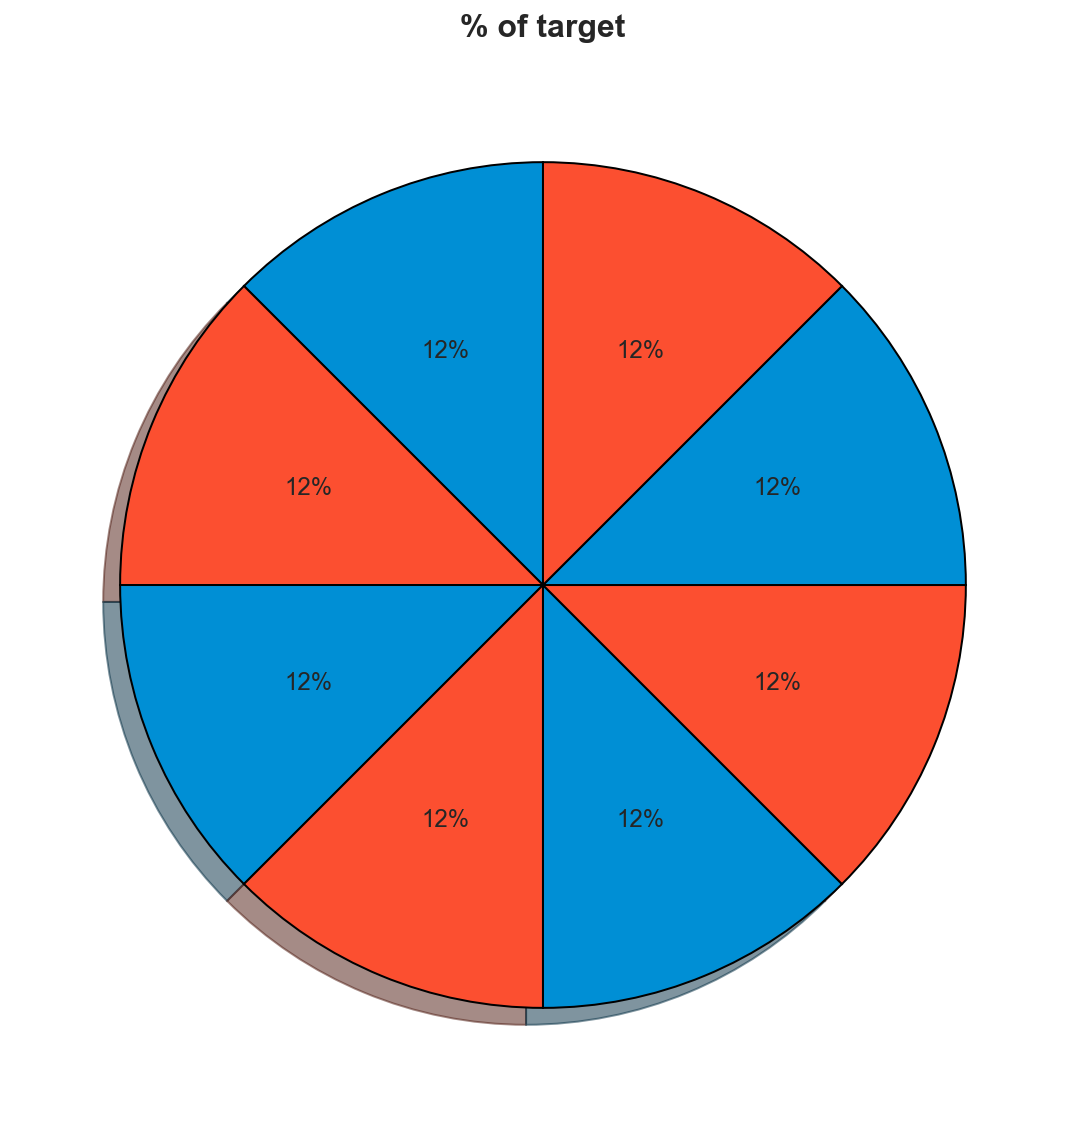

In [601]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [602]:
X = raw_df.drop(['match_id'], axis=1)


In [603]:
y = X.pop(TARGETNAME)

In [604]:
X.fillna('', inplace=True)

In [605]:
X.dtypes

augment0              object
augment1              object
augment2              object
Set7_Bruiser         float32
Set7_Cavalier        float32
                      ...   
TFT7_Aatrox_item0     object
TFT7_Aatrox_item1     object
TFT7_Aatrox_item2     object
TFT7_Senna_item1      object
TFT7_Senna_item2      object
Length: 265, dtype: object

In [606]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [607]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [608]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [609]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8616 entries, 0 to 8615
Columns: 265 entries, augment0 to TFT7_Senna_item2
dtypes: int64(87), object(178)
memory usage: 17.4+ MB


In [610]:
X

,augment0,augment1,augment2,Set7_Bruiser,Set7_Cavalier,Set7_Dragon,Set7_Guardian,Set7_Guild,Set7_Mage,Set7_Ragewing,...,TFT7_TahmKench_item2,TFT7_Senna_item0,TFT7_Vladimir_item2,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Aatrox_item0,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2
0,TFT6_Augment_PortableForge,TFT7_Augment_DragonHorde,TFT7_Augment_WhispersEmblem2,1,0,2,0,1,0,1,...,,,,,,,,,,
1,TFT6_Augment_ThreesCompany,TFT7_Augment_FirstAidKit2,TFT6_Augment_TheGoldenEgg,0,0,1,0,0,0,0,...,,,,,,,,,,
2,TFT6_Augment_TrueTwos,TFT6_Augment_PortableForge,TFT6_Augment_VerdantVeil,0,0,1,1,1,0,0,...,,,,,,,,,,
3,TFT6_Augment_MetabolicAccelerator,TFT7_Augment_SwiftshotPressTheAttack,TFT7_Augment_BruiserEmblem2,3,0,0,0,1,0,0,...,,,,,,,,,,
4,TFT7_Augment_BruiserPersonalTraining,TFT7_Augment_WarriorTiamat,TFT6_Augment_VerdantVeil,2,0,0,0,0,0,0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8611,TFT6_Augment_TargetDummies,TFT7_Augment_ShapeshifterTrait,TFT6_Augment_JeweledLotus,0,0,0,0,0,0,1,...,,,,,,,,,,
8612,TFT6_Augment_PortableForge,TFT7_Augment_DragonmancerTrait,TFT6_Augment_Ascension,0,0,1,0,0,0,1,...,,,,,,,,,,
8613,TFT6_Augment_SecondWind2,TFT7_Augment_BandOfThieves1,TFT6_Augment_Ascension,0,0,1,0,1,0,0,...,,,,,,,,,,
8614,TFT6_Augment_RichGetRicher,TFT6_Augment_ItemGrabBag1,TFT6_Augment_TargetDummies,0,0,1,0,0,0,0,...,,,,,,,,,,


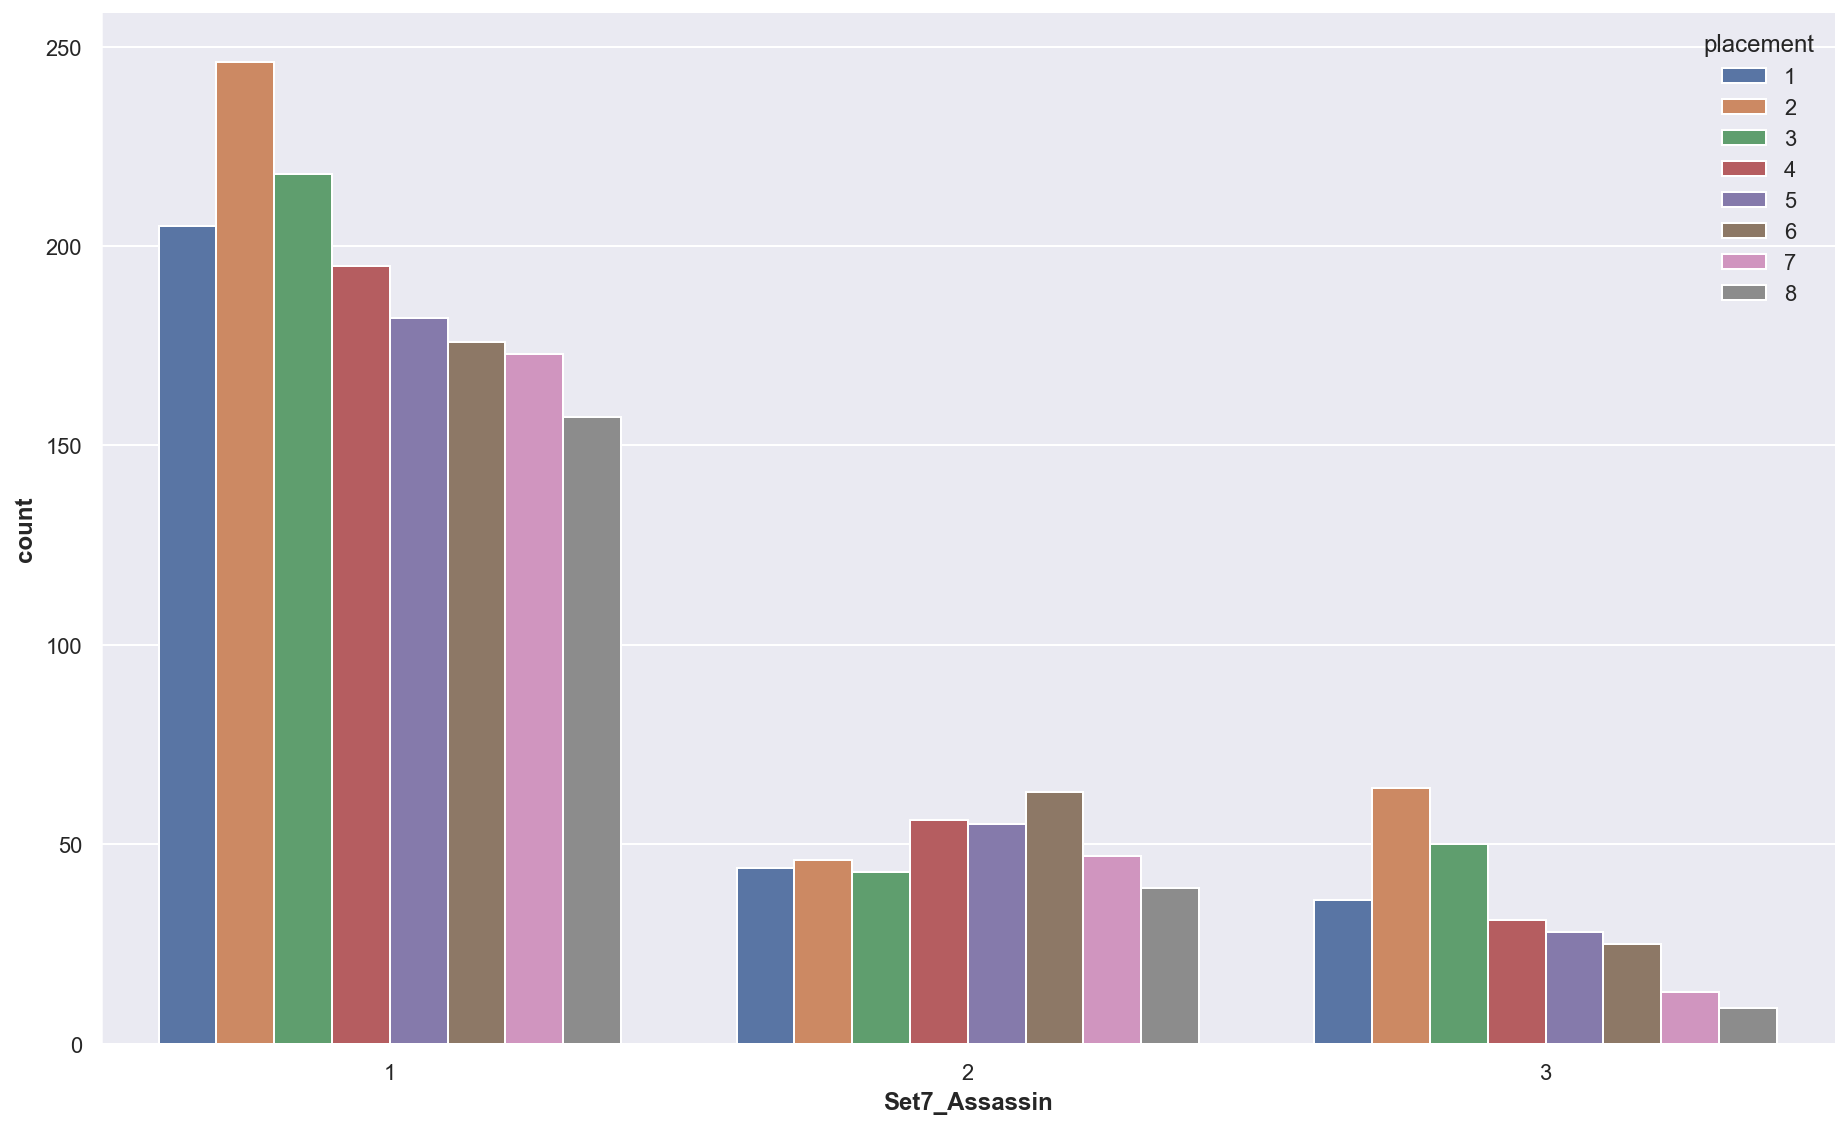

In [611]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Assassin']>0], x='Set7_Assassin', hue=TARGETNAME)
sns.despine()

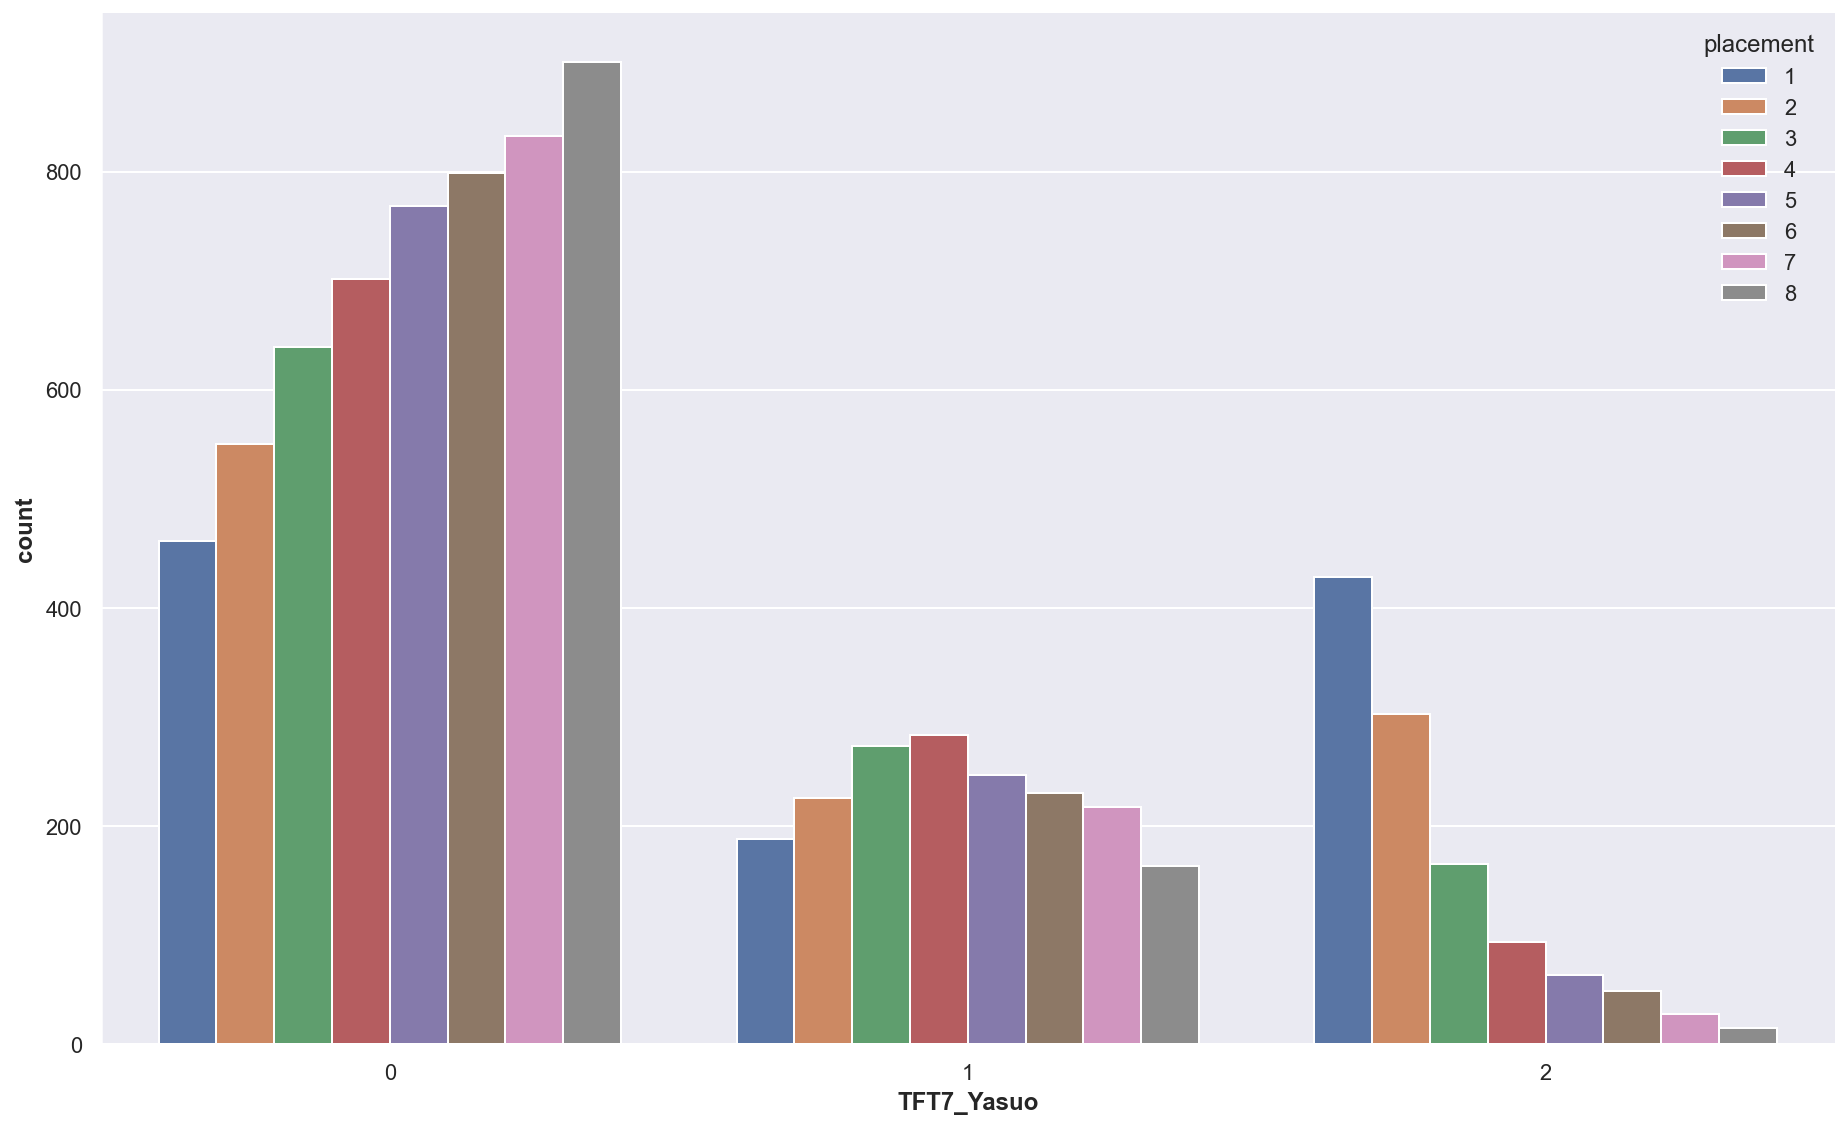

In [612]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Yasuo', hue=TARGETNAME)
sns.despine()

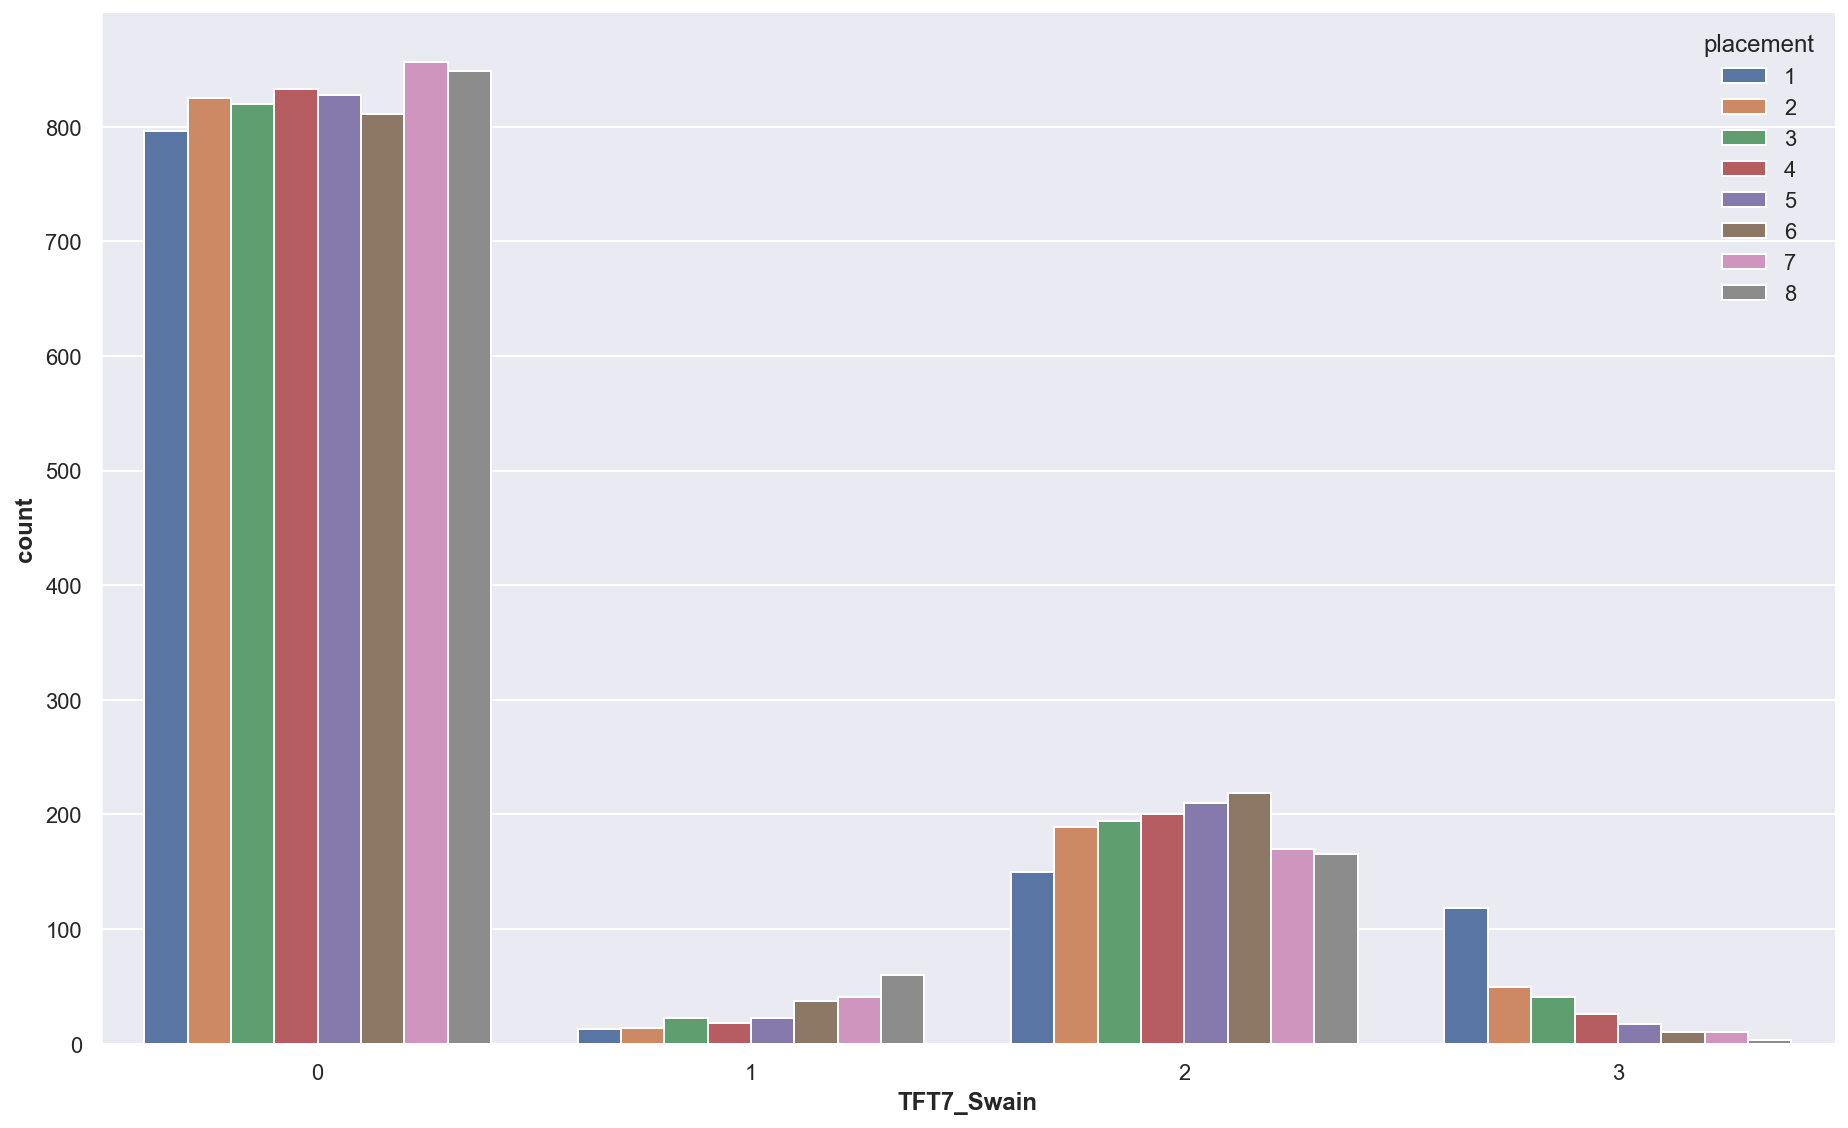

In [613]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Swain', hue=TARGETNAME)
sns.despine()

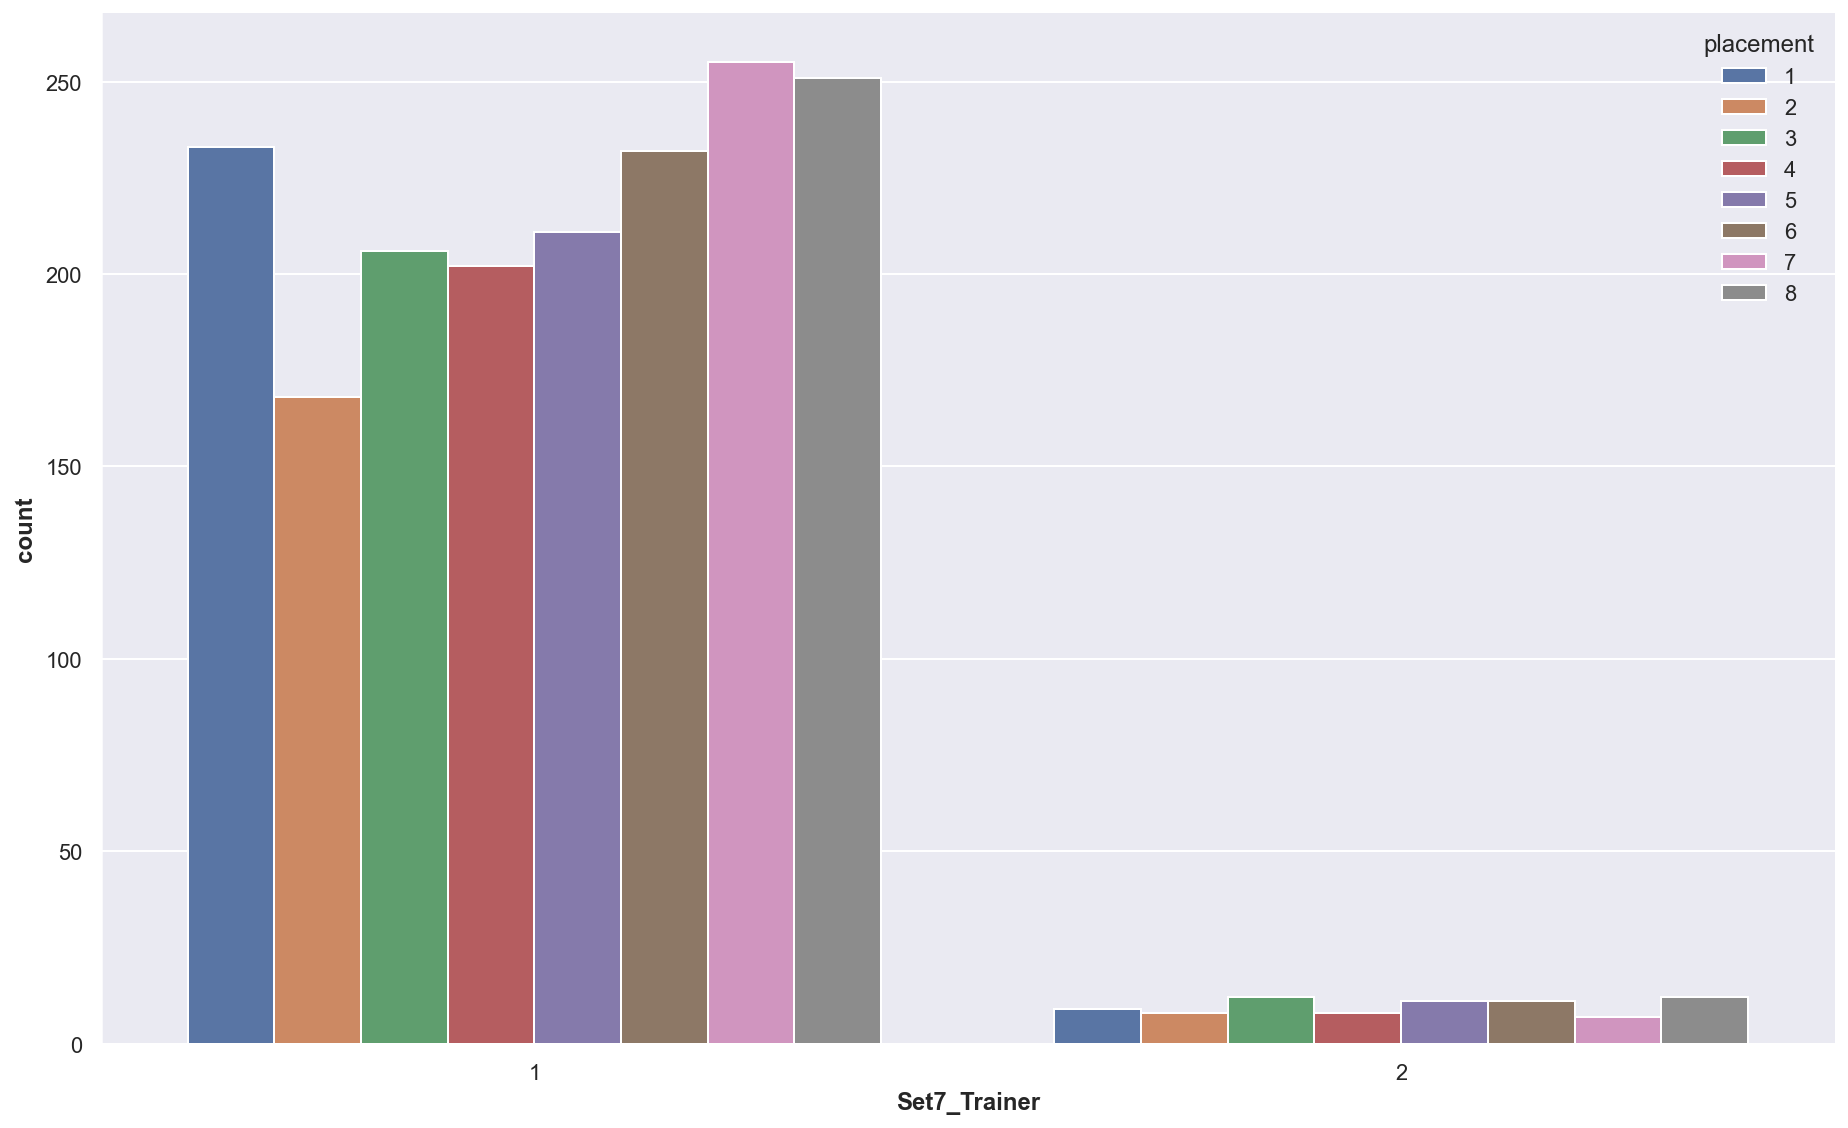

In [614]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Trainer']>0], x='Set7_Trainer', hue=TARGETNAME)
sns.despine()

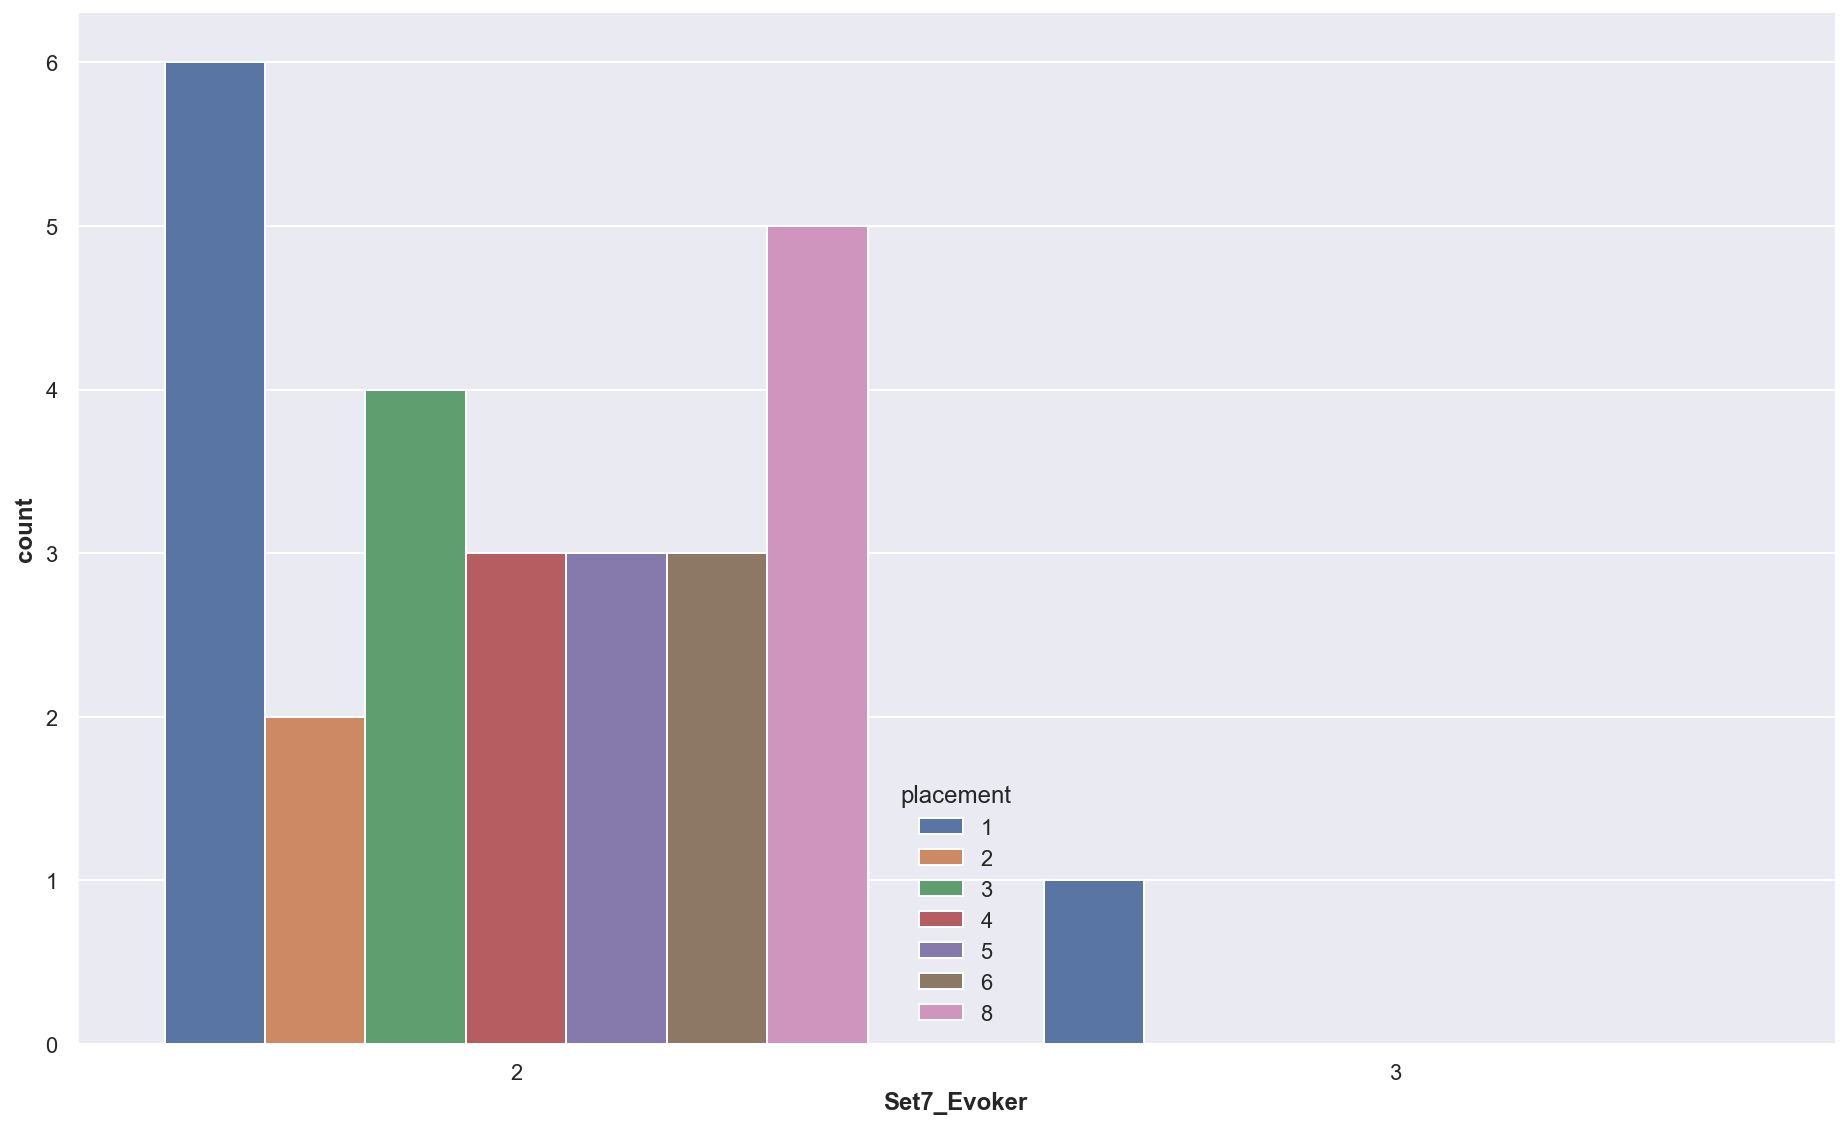

In [615]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Evoker']>1], x='Set7_Evoker', hue=TARGETNAME)
sns.despine()

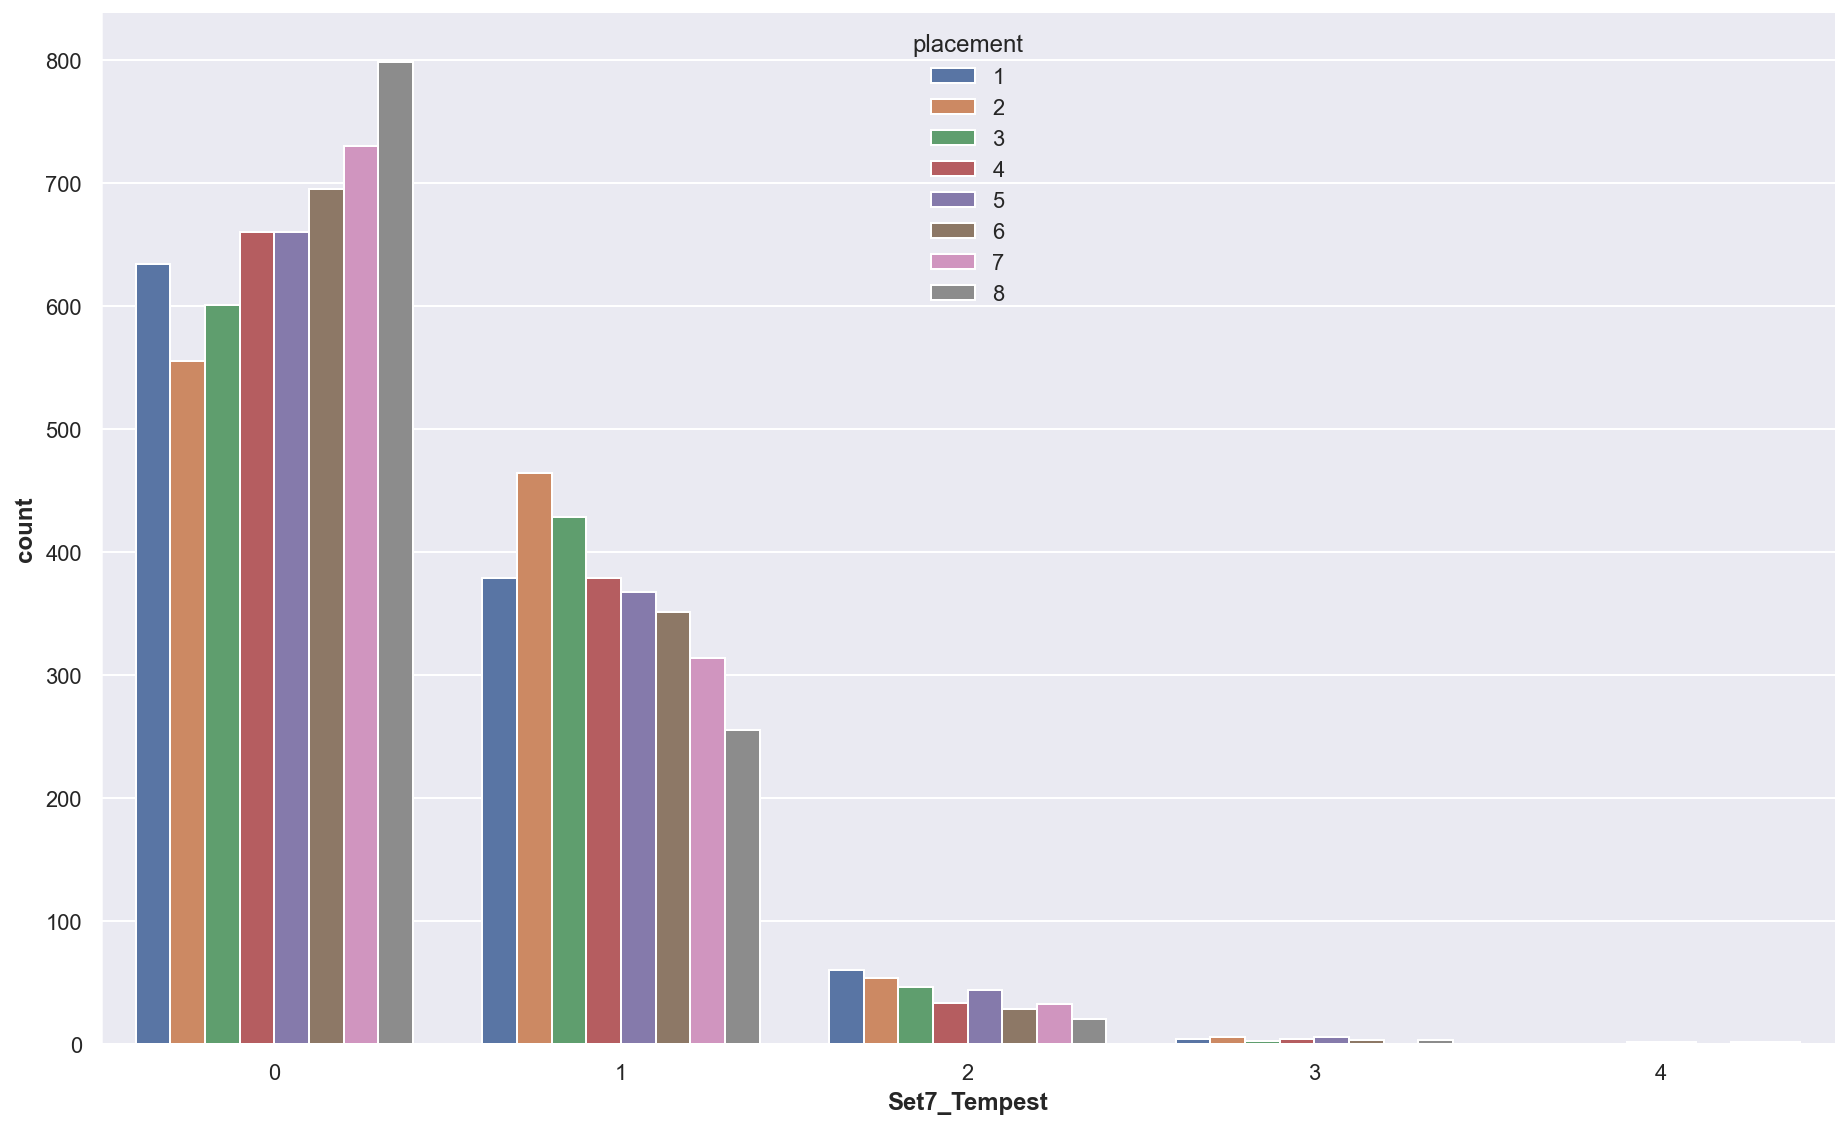

In [616]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Tempest', hue=TARGETNAME)
sns.despine()

In [617]:
# X[categorical_cols] = X[categorical_cols].applymap(np.int64)

In [618]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [619]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='mae', tree_method='hist',
                    n_estimators=250, enable_categorical=True) #, use_label_encoder=False hist

In [620]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
augment_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
item_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
preproc = StandardScaler()

# Encode label. 0 = Show , 1 = No Show
y = le_target.fit_transform(y)

In [621]:
# augment_oe.fit(X[categorical_cols[:3]])

In [622]:
# item_oe.fit(X[categorical_cols[3:]])

In [623]:
# categorical_cols[3:]

In [624]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, categorical_cols),
            # ("augment", augment_oe, categorical_cols[:3]),
            # ("item", item_oe, categorical_cols[3:]),
        ],
        remainder=preproc,
        verbose_feature_names_out=False,
    ),
    xgb,
)

In [625]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('one_hot_time',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['augment0', 'augment1',
                                                   'augment2',
                                                   'TFT7_Thresh_item0',
                                                   'TFT7_Twitch_item0',
                                                   'TFT7_Sylas_item0',
                                                   'TFT7_Sylas_item1',
                                                   'TFT7_Sylas_item2',
                                                   'TFT7_Hecarim_item0',
                                                   'TFT7_Hecarim_item1',
                                                   'TFT7_Hecarim...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [626]:
y_pred = logistic_regression_pipeline.predict(X_test)

In [627]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [628]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [629]:
len(y_test)

1293

In [630]:
y_pred.shape

(1293,)

In [631]:
def plot_oof(y_true, y_predict):
    # Plot y_true vs. y_pred
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_predict, s=3, color='r', alpha=0.5)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

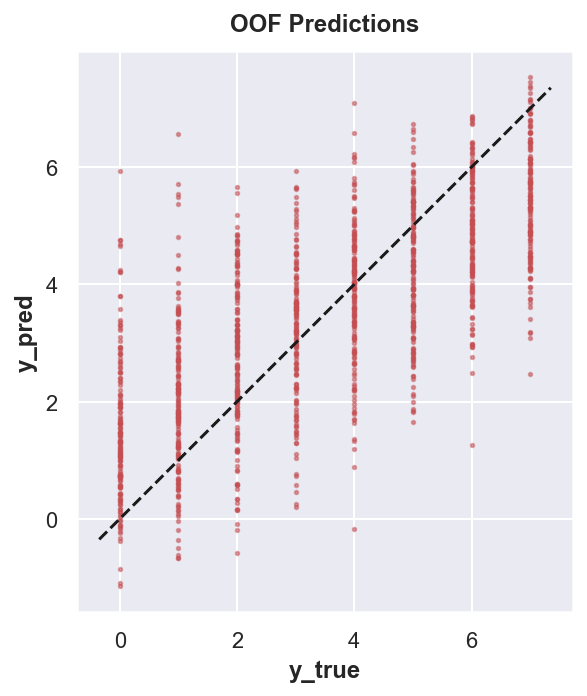

In [632]:
plot_oof(y_test, y_pred)

In [633]:
min(y_pred)

-1.1475034

In [634]:
mean_absolute_error(y_test, y_pred)

1.2462462130660295

In [635]:
mean_squared_error(y_test, y_pred)

2.443509122873527

In [636]:
# logistic_regression_pipeline[:-1].get_feature_names_out()
feature_names = logistic_regression_pipeline[:-1].get_feature_names_out()
mdi_importances = pd.Series(
    logistic_regression_pipeline[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

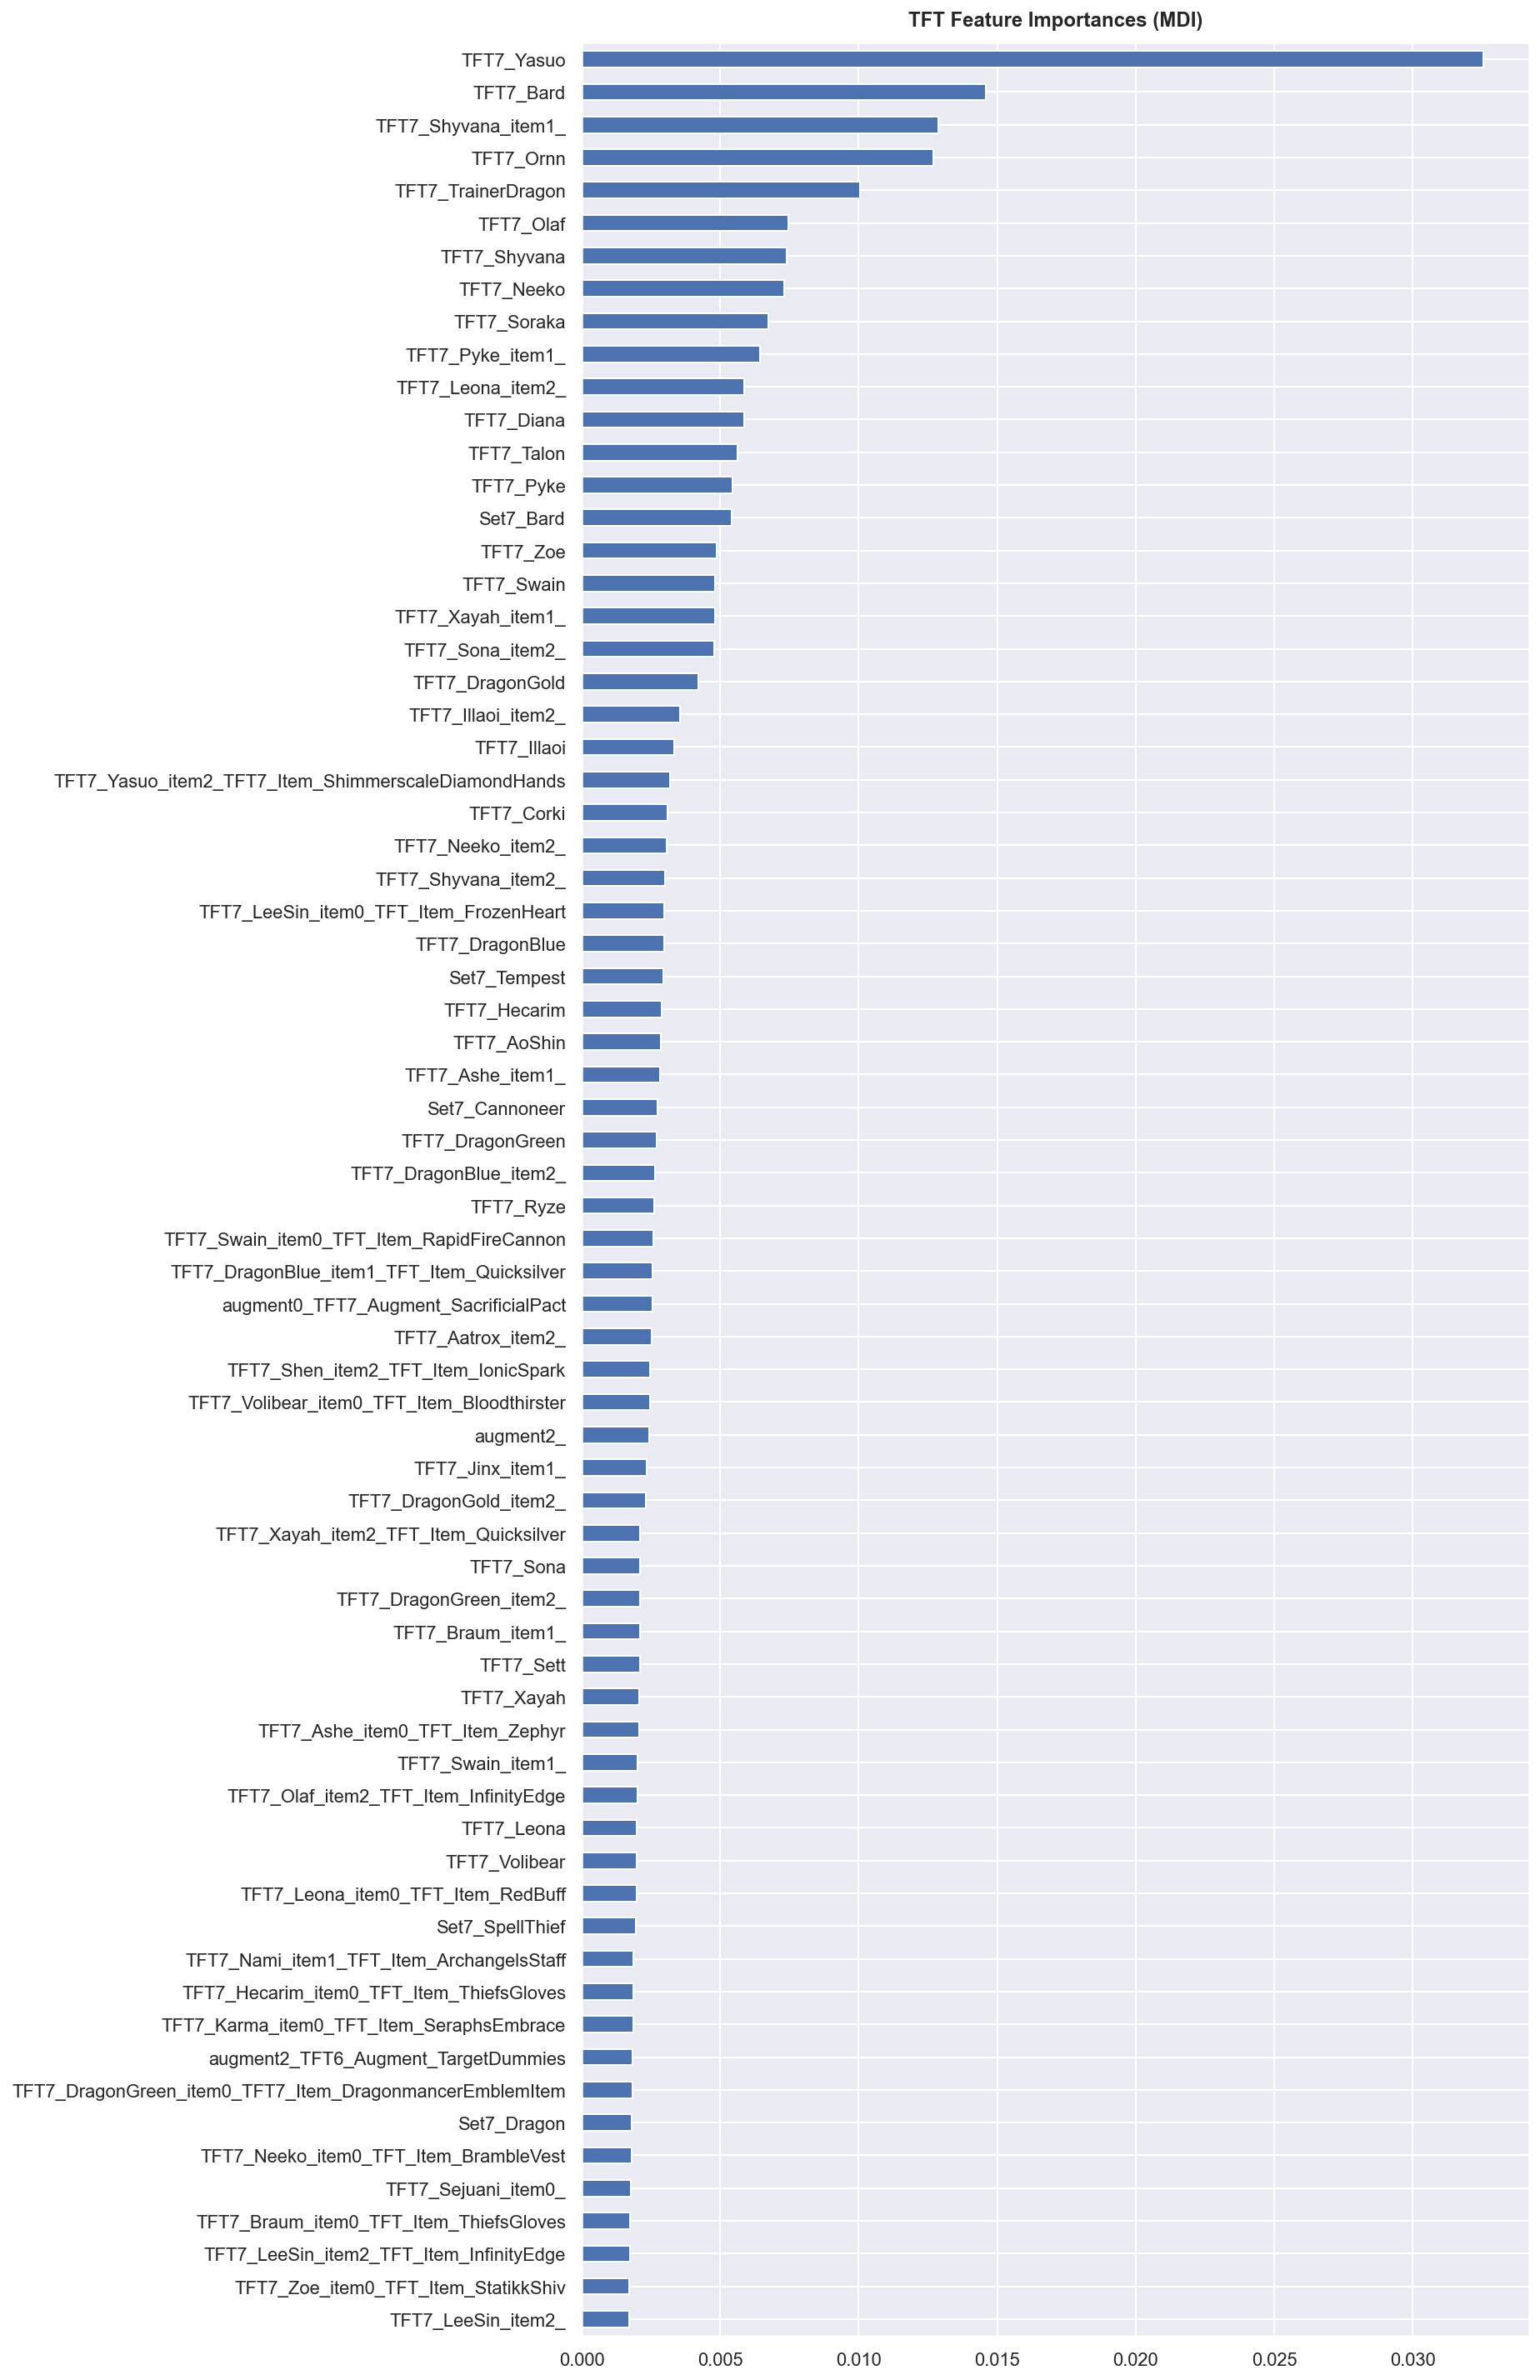

In [637]:
plt.figure(figsize=(13, 20))
ax = mdi_importances[-70:].plot.barh()
ax.set_title("TFT Feature Importances (MDI)")
ax.figure.tight_layout()

In [638]:
mdi_importances.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_mdi_importances.csv'))

In [639]:
mdi_importances[-60:]

TFT7_Hecarim_item0_TFT_Item_ThiefsGloves               0.001861
TFT7_Nami_item1_TFT_Item_ArchangelsStaff               0.001862
Set7_SpellThief                                        0.001952
TFT7_Leona_item0_TFT_Item_RedBuff                      0.001976
TFT7_Volibear                                          0.001980
TFT7_Leona                                             0.001990
TFT7_Olaf_item2_TFT_Item_InfinityEdge                  0.001997
TFT7_Swain_item1_                                      0.002021
TFT7_Ashe_item0_TFT_Item_Zephyr                        0.002069
TFT7_Xayah                                             0.002075
TFT7_Sett                                              0.002095
TFT7_Braum_item1_                                      0.002100
TFT7_DragonGreen_item2_                                0.002100
TFT7_Sona                                              0.002112
TFT7_Xayah_item2_TFT_Item_Quicksilver                  0.002114
TFT7_DragonGold_item2_                  